In [1]:
# POTATO Example Notebook for SemEval-2010 Task 8 Relation Extraction
# This notebook demonstrates POTATO's capabilities for interpretable graph-based relation extraction

import json
import pandas as pd
from sklearn.model_selection import train_test_split
from xpotato.dataset.dataset import Dataset
from xpotato.models.trainer import GraphTrainer
from xpotato.graph_extractor.extract import FeatureEvaluator
from xpotato.models.utils import to_dot
from graphviz import Source

print("="*80)
print("POTATO: Interpretable Graph-based Relation Extraction")
print("Dataset: SemEval-2010 Task 8")
print("="*80)

/Users/berke/Desktop/School/TU_Wien-MSC/2025W/194.093_NLP-IE/Project/Token13-tuw-nlp-ie-2025WS/.potato_ui_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


POTATO: Interpretable Graph-based Relation Extraction
Dataset: SemEval-2010 Task 8


In [2]:
# Verify Environment
import sys
import importlib.util

print("Environment Check:")
print("="*80)
print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")

# Check if we're in the correct environment
if 'potato_ui_env' in sys.executable:
    print("✓ Running in potato_ui_env - Good!")
else:
    print("⚠️  WARNING: Not running in potato_ui_env!")
    print("   Please select the potato_ui_env kernel to avoid dependency conflicts.")
    print("   Path should contain: potato/potato_ui_env/bin/python")

# Check key package versions
try:
    import pandas
    import jinja2
    import numpy
    print(f"\npandas: {pandas.__version__} (should be ~1.5.3)")
    print(f" jinja2: {jinja2.__version__} (should be 3.0.1)")
    print(f" numpy: {numpy.__version__} (should be ~1.23.5)")
except ImportError as e:
    print(f"\nMissing package: {e}")
    print("Run: pip install -e ./potato_frontend/")

print("="*80)

Environment Check:
Python executable: /Users/berke/Desktop/School/TU_Wien-MSC/2025W/194.093_NLP-IE/Project/Token13-tuw-nlp-ie-2025WS/.potato_ui_env/bin/python
Python version: 3.10.4 (v3.10.4:9d38120e33, Mar 23 2022, 17:29:05) [Clang 13.0.0 (clang-1300.0.29.30)]
✓ Running in potato_ui_env - Good!

✓ pandas: 2.3.3 (should be ~1.5.3)
✓ jinja2: 3.0.1 (should be 3.0.1)
✓ numpy: 1.26.4 (should be ~1.23.5)


In [3]:
# 1. Load and Prepare the Dataset
print("\n1. Loading SemEval-2010 Task 8 Data...")
print("-" * 80)

# Load test data
test_df = pd.read_csv('../data/processed/test/test_df.csv')

# Load FULL training data (using JSON with all training examples)
train_df = pd.read_json('../data/processed/train/train.json')

print(f"Test set size: {len(test_df)}")
print(f"Train set size (FULL): {len(train_df)}")

# Display relation distribution
print("\nRelation distribution in test set:")
print(test_df['relation_type'].value_counts())

# Display some examples
print("\n" + "="*80)
print("Sample sentences:")
print("="*80)
for i in range(3):
    print(f"\n{i+1}. Sentence: {test_df.iloc[i]['text']}")
    print(f"   Entities: [{test_df.iloc[i]['entity1_text']}] and [{test_df.iloc[i]['entity2_text']}]")
    print(f"   Relation: {test_df.iloc[i]['relation_type']}")


1. Loading SemEval-2010 Task 8 Data...
--------------------------------------------------------------------------------
Test set size: 2717
Train set size (FULL): 8000

Relation distribution in test set:
relation_type
Other                 454
Cause-Effect          328
Component-Whole       312
Entity-Destination    292
Message-Topic         261
Entity-Origin         258
Member-Collection     233
Product-Producer      231
Content-Container     192
Instrument-Agency     156
Name: count, dtype: int64

Sample sentences:

1. Sentence: The most common audits were about waste and recycling.
   Entities: [audits] and [waste]
   Relation: Message-Topic

2. Sentence: The company fabricates plastic chairs.
   Entities: [company] and [chairs]
   Relation: Product-Producer

3. Sentence: The school master teaches the lesson with a stick.
   Entities: [master] and [stick]
   Relation: Instrument-Agency


## Step 1: Data Preparation

First, we load the SemEval-2010 Task 8 data and explore its structure. The dataset contains sentences with two marked entities and their semantic relation. We'll use the **full training dataset** for POTATO feature extraction.

In [4]:
# 2. Initialize POTATO Dataset with ALL Data
print("\n2. Preparing POTATO Dataset...")
print("-" * 80)

# Use ALL training data for POTATO
print("Using full training dataset...")
demo_df = train_df.copy()

# Prepare sentences in POTATO format: (text, label)
sentences = [(row['text'], row['relation']['type']) for _, row in demo_df.iterrows()]

print(f"Using {len(sentences)} training sentences from {len(demo_df['relation'].apply(lambda x: x['type']).unique())} relation types")
print("\nRelation distribution in dataset:")
print(demo_df['relation'].apply(lambda x: x['type']).value_counts())
# Create label vocabulary from all unique labels
unique_labels = sorted(demo_df['relation'].apply(lambda x: x['type']).unique().tolist())
label_vocab = {label: idx for idx, label in enumerate(unique_labels)}

print(f"\nLabel vocabulary ({len(label_vocab)} classes):")
for label, idx in sorted(label_vocab.items(), key=lambda x: x[1]):
    print(f"  {idx}: {label}")


2. Preparing POTATO Dataset...
--------------------------------------------------------------------------------
Using full training dataset...
Using 8000 training sentences from 10 relation types

Relation distribution in dataset:
relation
Other                 1410
Cause-Effect          1003
Component-Whole        941
Entity-Destination     845
Product-Producer       717
Entity-Origin          716
Member-Collection      690
Message-Topic          634
Content-Container      540
Instrument-Agency      504
Name: count, dtype: int64

Label vocabulary (10 classes):
  0: Cause-Effect
  1: Component-Whole
  2: Content-Container
  3: Entity-Destination
  4: Entity-Origin
  5: Instrument-Agency
  6: Member-Collection
  7: Message-Topic
  8: Other
  9: Product-Producer


## Step 2: Parse Sentences into Graphs

POTATO works with graph representations. We'll use **UD (Universal Dependencies)** graphs, which are well-suited for relation extraction tasks.

In [5]:
# Download Stanza resources (required for UD parsing)
print("\nDownloading Stanza resources for English...")
print("-" * 80)

import stanza

try:
    # Download English model for dependency parsing
    stanza.download('en', verbose=False)
    print("✓ Stanza resources downloaded successfully!")
except Exception as e:
    print(f"Note: {e}")
    print("Attempting to continue anyway...")


--------------------------------------------------------------------------------
✓ Stanza resources downloaded successfully!


In [6]:
# 3. Parse graphs using POTATO
print("\n3. Parsing graphs with POTATO...")
print("-" * 80)
print("Note: This may take a moment as we parse sentences into dependency graphs\n")

# Fix for PyTorch weights loading issue with Stanza
import torch
torch.serialization.add_safe_globals([type(lambda: None)])

# Initialize POTATO dataset
graph_format = "ud"  # Universal Dependencies
dataset = Dataset(sentences, label_vocab=label_vocab, lang="en")

# Parse sentences into graphs
try:
    dataset.set_graphs(dataset.parse_graphs(graph_format=graph_format))
except Exception as e:
    print(f"Error during parsing: {e}")
    print("\nTrying alternative approach with torch.load settings...")
    
    # Alternative: Set torch to use weights_only=False for compatibility
    import torch._C as _C
    original_load = torch.load
    torch.load = lambda *args, **kwargs: original_load(*args, **{**kwargs, 'weights_only': False})
    
    dataset.set_graphs(dataset.parse_graphs(graph_format=graph_format))
    torch.load = original_load

# Convert to dataframe
df = dataset.to_dataframe()

print("✓ Graph parsing complete!")
print(f"Dataset shape: {df.shape}")
print("\nFirst few examples:")
print(df[['text', 'label']].head())


3. Parsing graphs with POTATO...
--------------------------------------------------------------------------------
Note: This may take a moment as we parse sentences into dependency graphs



/Users/berke/Desktop/School/TU_Wien-MSC/2025W/194.093_NLP-IE/Project/Token13-tuw-nlp-ie-2025WS/.potato_ui_env/lib/python3.10/site-packages/torch/_weights_only_unpickler.py:552: UserWarning: Detected pickle protocol 3 in the checkpoint, which was not the default pickle protocol used by `torch.load` (2). The weights_only Unpickler might not support all instructions implemented by this protocol, please file an issue for adding support if you encounter this.
  warnings.warn(


Error during parsing: Vector file is not provided.

Trying alternative approach with torch.load settings...


2025-11-25 00:59:27,149 : pipeline (57) - INFO - creating new NLP cache in /Users/berke/Desktop/School/TU_Wien-MSC/2025W/194.093_NLP-IE/Project/Token13-tuw-nlp-ie-2025WS/.potato_ui_env/lib/python3.10/site-packages/xpotato/graph_extractor/cache/en_nlp_cache.json
100%|██████████| 8000/8000 [08:57<00:00, 14.88it/s]  


✓ Graph parsing complete!
Dataset shape: (8000, 4)

First few examples:
                                                text              label
0  The system as described above has its greatest...    Component-Whole
1  The child was carefully wrapped and bound into...              Other
2  The author of a keygen uses a disassembler to ...  Instrument-Agency
3              A misty ridge uprises from the surge.              Other
4  The student association is the voice of the un...  Member-Collection


## Step 3: Visualize Graph Structure

Let's visualize one of the parsed graphs to understand how POTATO represents sentences.


4. Visualizing Sample Graph
--------------------------------------------------------------------------------
Sentence: People have been moving back into downtown.
Relation: Entity-Destination

Graph visualization:


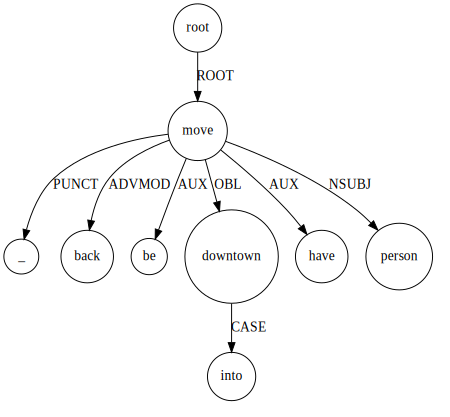

In [7]:
# 4. Visualize a sample graph
print("\n4. Visualizing Sample Graph")
print("-" * 80)

# Select an interesting example (Entity-Destination relation)
sample_idx = df[df['label'] == 'Entity-Destination'].index[0]
sample_row = df.iloc[sample_idx]

print(f"Sentence: {sample_row.text}")
print(f"Relation: {sample_row.label}")
print("\nGraph visualization:")

# Visualize the graph
Source(to_dot(sample_row.graph))

## Step 4: Simple Rule Matching

Now let's write and test some simple rules. POTATO uses PENMAN notation to describe graph patterns.

### Example 1: Single Node Feature

In [8]:
# 5. Initialize Feature Evaluator
print("\n5. Rule Matching Examples")
print("="*80)

evaluator = FeatureEvaluator()

# Example 1: Simple node feature - looking for "into" (common in Entity-Destination)
print("\nExample 1: Matching simple node feature '(u_1 / into)'")
print("-" * 80)

rule1 = [[["(u_1 / into)"], [], "Entity-Destination"]]
matched_df1 = evaluator.match_features(df, rule1)

print(f"Matched {len(matched_df1)} sentences:")
# Display available columns (the matched dataframe has different column names)
if len(matched_df1) > 0:
    print("\nMatched examples:")
    for idx, row in matched_df1.head().iterrows():
        print(f"  - {row['Sentence']}")
        print(f"    Predicted: {row['Predicted label']}, Actual: {row.get('Label', 'N/A')}")
        print()


5. Rule Matching Examples

Example 1: Matching simple node feature '(u_1 / into)'
--------------------------------------------------------------------------------


8000it [00:01, 7856.90it/s]

Matched 8000 sentences:

Matched examples:
  - The system as described above has its greatest application in an arrayed configuration of antenna elements.
    Predicted: , Actual: N/A

  - The child was carefully wrapped and bound into the cradle by means of a cord.
    Predicted: Entity-Destination, Actual: N/A

  - The author of a keygen uses a disassembler to look at the raw assembly code.
    Predicted: , Actual: N/A

  - A misty ridge uprises from the surge.
    Predicted: , Actual: N/A

  - The student association is the voice of the undergraduate student population of the State University of New York at Buffalo.
    Predicted: , Actual: N/A



### Example 2: Subgraph Feature with Multiple Nodes

In [9]:
# Example 2: More specific subgraph with connected nodes
print("\nExample 2: Matching subgraph '(u_1 / cause :nsubj (u_2 / .*))' for Cause-Effect")
print("-" * 80)

rule2 = [[["(u_1 / cause :nsubj (u_2 / .*))"], [], "Cause-Effect"]]
matched_df2 = evaluator.match_features(df, rule2)

print(f"Matched {len(matched_df2)} sentences:")
if len(matched_df2) > 0:
    print("\nMatched examples:")
    for idx, row in matched_df2.head().iterrows():
        print(f"  - {row['Sentence']}")
else:
    print("No matches found. Let's try a different pattern...")


Example 2: Matching subgraph '(u_1 / cause :nsubj (u_2 / .*))' for Cause-Effect
--------------------------------------------------------------------------------


8000it [00:00, 8517.83it/s]

Matched 8000 sentences:

Matched examples:
  - The system as described above has its greatest application in an arrayed configuration of antenna elements.
  - The child was carefully wrapped and bound into the cradle by means of a cord.
  - The author of a keygen uses a disassembler to look at the raw assembly code.
  - A misty ridge uprises from the surge.
  - The student association is the voice of the undergraduate student population of the State University of New York at Buffalo.


### Example 3: Using Regex and Negated Features

In [10]:
# Example 3: Using regex to match any connected node
print("\nExample 3: Using regex '(u_1 / produce :nsubj (u_2 / .*))' for Product-Producer")
print("-" * 80)

rule3 = [[["(u_1 / produce :nsubj (u_2 / .*))"], [], "Product-Producer"]]
matched_df3 = evaluator.match_features(df, rule3)

print(f"Matched {len(matched_df3)} sentences:")
if len(matched_df3) > 0:
    print("\nMatched examples:")
    for idx, row in matched_df3.head().iterrows():
        print(f"  - {row['Sentence']}")
else:
    print("No matches found with this pattern.")

# Example with negated features
print("\nExample 3b: Matching with negated features")
print("-" * 80)
print("Rule: Match 'into' but NOT 'from' (to be more specific for Entity-Destination)")

rule3b = [[["(u_1 / into)"], ["(u_2 / from)"], "Entity-Destination"]]
matched_df3b = evaluator.match_features(df, rule3b)

print(f"Matched {len(matched_df3b)} sentences (vs {len(matched_df1)} without negation)")
if len(matched_df3b) > 0 and len(matched_df3b) < len(matched_df1):
    print("✓ Negation reduced false positives!")


Example 3: Using regex '(u_1 / produce :nsubj (u_2 / .*))' for Product-Producer
--------------------------------------------------------------------------------


8000it [00:00, 9736.02it/s] 


Matched 8000 sentences:

Matched examples:
  - The system as described above has its greatest application in an arrayed configuration of antenna elements.
  - The child was carefully wrapped and bound into the cradle by means of a cord.
  - The author of a keygen uses a disassembler to look at the raw assembly code.
  - A misty ridge uprises from the surge.
  - The student association is the voice of the undergraduate student population of the State University of New York at Buffalo.

Example 3b: Matching with negated features
--------------------------------------------------------------------------------
Rule: Match 'into' but NOT 'from' (to be more specific for Entity-Destination)


8000it [00:01, 5955.37it/s]

Matched 8000 sentences (vs 8000 without negation)


## Step 5: Train Features from Data

POTATO can automatically extract and rank graph features based on their statistical relevance.

In [11]:
# 6. Train a regex feature to specialize it
print("\n6. Training Features")
print("="*80)

# Train a generic regex feature to replace wildcards with specific nodes
print("\nTraining regex feature for Entity-Destination")
print("This will find the most relevant patterns for the relation")
print("-" * 80)

# Try a simpler pattern that's more likely to match
try:
    # Try training with a pattern that matches "into" with any connection
    trained_feature = evaluator.train_feature(
        "Entity-Destination", 
        "(u_1 / into :.*[0-9]+ (u_2 / .*))", 
        df
    )
    print(f"\nTrained feature: {trained_feature}")
    print("\nThis feature replaces '.*' with specific nodes that are statistically significant.")
except Exception as e:
    print(f"Training with complex pattern failed: {e}")
    print("\nTrying simpler pattern...")
    
    # Fallback to an even simpler pattern
    try:
        trained_feature = evaluator.train_feature(
            "Entity-Destination", 
            "(u_1 / into)", 
            df
        )
        print(f"\nTrained feature: {trained_feature}")
    except Exception as e2:
        print(f"Note: Feature training requires patterns that match the data.")
        print(f"The pattern may not exist in this subset. Error: {e2}")
        print("\nIn a full dataset, POTATO would extract and train more complex patterns.")


6. Training Features

Training regex feature for Entity-Destination
This will find the most relevant patterns for the relation
--------------------------------------------------------------------------------
Training with complex pattern failed: local variable 'feature' referenced before assignment

Trying simpler pattern...
Note: Feature training requires patterns that match the data.
The pattern may not exist in this subset. Error: 'NoneType' object has no attribute 'edges'

In a full dataset, POTATO would extract and train more complex patterns.


## Step 6: Automatic Feature Extraction

Now let's use POTATO's GraphTrainer to automatically extract and rank features from the data.

In [12]:
# 7. Automatic feature extraction using GraphTrainer
print("\n7. Automatic Feature Extraction")
print("="*80)

# Split data for training
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

print(f"Training set: {len(train_df)} examples")
print(f"Validation set: {len(val_df)} examples")

# Initialize GraphTrainer
trainer = GraphTrainer(train_df)

print("\nExtracting features from the training data...")
print("This will find graph patterns that are statistically relevant for each relation type.")
print("-" * 80)

# Extract features with minimum edge constraint
# min_edge=1 means we only consider features with at least one edge (connected nodes)
features = trainer.prepare_and_train(min_edge=1)

print("\n✓ Feature extraction complete!")
print(f"\nFound features for {len(features)} relation types")


7. Automatic Feature Extraction
Training set: 5600 examples
Validation set: 2400 examples
Initializing trainer object...

Extracting features from the training data...
This will find graph patterns that are statistically relevant for each relation type.
--------------------------------------------------------------------------------
Featurizing graphs by generating subgraphs up to 2...


5600it [00:22, 249.88it/s]


Getting feature graphs...
Selecting the best features...
Generating training data...
Training...


/Users/berke/Desktop/School/TU_Wien-MSC/2025W/194.093_NLP-IE/Project/Token13-tuw-nlp-ie-2025WS/.potato_ui_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Getting features...

✓ Feature extraction complete!

Found features for 10 relation types


In [13]:
# 8. Examine extracted features for each relation type
print("\n8. Examining Top Features for Each Relation")
print("="*80)

for relation_type in sorted(features.keys()):
    print(f"\n{relation_type}:")
    print("-" * 60)
    top_features = features[relation_type][:3]  # Show top 3 features
    
    if len(top_features) > 0:
        for i, (feature, neg_features, label) in enumerate(top_features, 1):
            print(f"  {i}. {feature}")
    else:
        print("  No features found")

print("\n" + "="*80)


8. Examining Top Features for Each Relation

Cause-Effect:
------------------------------------------------------------
  1. ['(u_391 / result  :NSUBJ (u_52 / that))']
  2. ['(u_500 / man  :DET (u_2 / the))']
  3. ['(u_2823 / death  :DET (u_2 / the))']

Component-Whole:
------------------------------------------------------------
  1. ['(u_353 / building  :DET (u_2 / the))']
  2. ['(u_288 / patient  :DET (u_2 / the))']
  3. ['(u_1864 / image  :DET (u_2 / the))']

Content-Container:
------------------------------------------------------------
  1. ['(u_649 / bottle  :DET (u_28 / a))']
  2. ['(u_324 / suitcase  :DET (u_28 / a))']
  3. ['(u_673 / content  :DET (u_2 / the))']

Entity-Destination:
------------------------------------------------------------
  1. ['(u_408 / place  :CC (u_61 / and))']
  2. ['(u_1815 / space  :CASE (u_365 / into))']
  3. ['(u_893 / give  :AUX_PASS (u_40 / be))']

Entity-Origin:
------------------------------------------------------------
  1. ['(u_3844 / farm

## Step 7: Evaluate Features

Let's evaluate the quality of extracted features by checking their precision, recall, and F-score.

In [21]:
# 9. Evaluate feature performance
print("\n9. Feature Performance Evaluation")
print("="*80)

# Select a relation to evaluate in detail
relation_to_evaluate = "Entity-Destination"

if relation_to_evaluate in features and len(features[relation_to_evaluate]) > 0:
    print(f"\nEvaluating features for: {relation_to_evaluate}")
    print("-" * 80)
    
    # Get top 5 features for this relation
    top_features = features[relation_to_evaluate][:5]
    
    # Evaluate these features on training data
    eval_df, p_r_f_support = trainer.evaluator.evaluate_feature(
        relation_to_evaluate, 
        top_features, 
        train_df
    )
    
    print("\nTop 5 Features Performance:")
    # Check available columns first
    available_cols = [col for col in ['Feature', 'Precision', 'Recall', 'Fscore', 'TP', 'FP', 'FN'] if col in eval_df.columns]
    if available_cols:
        print(eval_df[available_cols])
    else:
        print(eval_df)
    
    print(f"\nOverall Performance Metrics for '{relation_to_evaluate}':")
    if p_r_f_support and len(p_r_f_support) == 4:
        print(f"  - Precision: {p_r_f_support[0]:.4f}")
        print(f"  - Recall:    {p_r_f_support[1]:.4f}")
        print(f"  - F1-score:  {p_r_f_support[2]:.4f}")
        print(f"  - Support:   {p_r_f_support[3]} (number of true instances)")
else:
    print(f"No features found for {relation_to_evaluate}")


9. Feature Performance Evaluation

Evaluating features for: Entity-Destination
--------------------------------------------------------------------------------

Top 5 Features Performance:
                                    Feature  Precision    Recall    Fscore
0       [(u_408 / place  :CC (u_61 / and))]   0.454545  0.008319  0.016340
1  [(u_1815 / space  :CASE (u_365 / into))]   1.000000  0.018303  0.035948
2   [(u_893 / give  :AUX_PASS (u_40 / be))]   0.307692  0.006656  0.013029
3    [(u_480 / put  :AUX_PASS (u_40 / be))]   0.733333  0.036606  0.069731
4   [(u_1272 / deliver  :PUNCT (u_13 / .))]   0.833333  0.024958  0.048465

Overall Performance Metrics for 'Entity-Destination':
  - Precision: 0.6951
  - Recall:    0.0948
  - F1-score:  0.1669
  - Support:   601 (number of true instances)


## Step 8: Save Results

Let's save the extracted features and the processed datasets for future use.

In [23]:
# 10. Save extracted features and datasets
print("\n10. Saving Results")
print("="*80)

# Save extracted features to JSON
features_path = "extracted_features.json"
with open(features_path, "w") as f:
    # Convert features to serializable format
    features_serializable = {
        label: [[feat, neg, lbl] for feat, neg, lbl in feature_list]
        for label, feature_list in features.items()
    }
    json.dump(features_serializable, f, indent=2)

print(f"Saved extracted features to: {features_path}")

# Save datasets using POTATO's utility
from xpotato.dataset.utils import save_dataframe

train_path = "potato_train_dataset.tsv"
val_path = "potato_val_dataset.tsv"

save_dataframe(train_df, train_path)
save_dataframe(val_df, val_path)

print(f"Saved training dataset to: {train_path}")
print(f"Saved validation dataset to: {val_path}")

print("\n" + "="*80)
print("POTATO Analysis Complete!")
print("="*80)


10. Saving Results
Saved extracted features to: extracted_features.json
Saved training dataset to: potato_train_dataset.tsv
Saved validation dataset to: potato_val_dataset.tsv

POTATO Analysis Complete!


## Summary

This notebook demonstrated POTATO's key capabilities:

1. **Data Loading**: Loaded SemEval-2010 Task 8 relation extraction data
2. **Graph Parsing**: Converted sentences to UD (Universal Dependencies) graphs
3. **Graph Visualization**: Visualized dependency structures
4. **Manual Rules**: Created and tested simple graph matching rules
5. **Regex Features**: Used wildcards and trained them to find specific patterns
6. **Automatic Feature Extraction**: Used GraphTrainer to automatically discover relevant features
7. **Feature Evaluation**: Measured precision, recall, and F-score of extracted features
8. **Results Saving**: Saved features and datasets for future use

### Key Advantages of POTATO:

- **Interpretable**: All features are human-readable graph patterns
- **Data-driven**: Automatically extracts statistically relevant features
- **Flexible**: Supports multiple graph types (UD, AMR, Fourlang)
- **Interactive**: Easy to write, test, and refine rules
- **Efficient**: Combines symbolic and statistical approaches

### Next Steps:

- Apply POTATO to the full training dataset for comprehensive feature extraction
- Combine POTATO features with neural models for hybrid approaches
- Use POTATO's frontend for interactive rule development
- Experiment with different graph types (AMR, Fourlang) for comparison

## Launch POTATO UI

The saved datasets and features can be used with POTATO's interactive Streamlit UI for visual rule development.

```
sh ../potato/launch_potato_ui.sh
```